In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import zipfile
from tqdm import tqdm

### Data preprocessing

In [166]:
data = pd.read_csv('./data/local_global_res_13_12.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36454 entries, 0 to 36453
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.1   36454 non-null  int64  
 1   Unnamed: 0     36010 non-null  float64
 2   train_time     36280 non-null  float64
 3   forecast_time  36280 non-null  float64
 4   MAE            36280 non-null  float64
 5   MSE            36280 non-null  float64
 6   RMSE           36280 non-null  float64
 7   MASE           36280 non-null  float64
 8   RMSSE          36280 non-null  float64
 9   MAPE           36280 non-null  float64
 10  SMAPE          36280 non-null  float64
 11  naming_orig    36454 non-null  object 
 12  model_name     36454 non-null  object 
 13  dataset_name   36454 non-null  object 
 14  horizon        36454 non-null  int64  
 15  split          36454 non-null  object 
 16  pred_time      0 non-null      float64
dtypes: float64(11), int64(2), object(4)
memory usage: 

Let's look at the data and display the number of unique values for each column. If column contains numeric data, min and max values (excluding NaNs) are displayed also.

In [138]:
data

,Unnamed: 0.1,Unnamed: 0,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,dataset_name,horizon,split,pred_time
0,0,0.0,3.812914,4.442261,18.260277,619.323792,24.886217,0.896638,0.792087,inf,16.386864,danish_atm_daily_5,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
1,1,0.0,3.485261,4.376619,28.395468,1160.189331,34.061552,1.088141,0.918072,41.157335,17.157184,danish_atm_daily_84,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
2,2,0.0,3.812914,4.442261,12.825266,269.356567,16.412086,0.814535,0.757765,39.022604,13.038494,danish_atm_daily_32,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
3,3,0.0,3.485261,4.376619,26.284388,1121.348877,33.486548,0.918232,0.792925,57.078475,18.962322,danish_atm_daily_25,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
4,4,0.0,3.485261,4.376619,15.145726,429.357697,20.720948,0.663444,0.597604,21.996029,10.027625,danish_atm_daily_6,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36449,0,NaN,225.815618,1.806664,2.762839,11.352131,3.369292,0.779592,0.688223,20.044580,8.785076,nn5_98,DeepARTuningObjective,nn5,30,validation,NaN
36450,0,NaN,221.914140,1.835336,2.712137,16.868277,4.107101,0.679580,0.778644,29.559124,10.474208,nn5_99,DeepARTuningObjective,nn5,30,test,NaN
36451,0,NaN,225.815618,1.806664,1.519503,3.326512,1.823873,0.381234,0.345513,11.370875,5.622922,nn5_99,DeepARTuningObjective,nn5,30,validation,NaN
36452,0,NaN,221.914140,1.835336,3.380999,22.316181,4.724001,0.658609,0.684295,23.539458,8.428656,nn5_9,DeepARTuningObjective,nn5,30,test,NaN


In [139]:
from pandas.api.types import is_numeric_dtype

sizes = pd.DataFrame(index=data.columns, columns=['unique_values', 'min', 'max'])

for col in data.columns:
    # for each column calculate number of unique values
    sizes.loc[col]['unique_values'] = len(data[col].unique())
    if is_numeric_dtype(data[col]):
        try:
            # if data type is numeric, try to calculate min and max values,
            # excluding NaNs
            sizes.loc[col]['min'] = np.min(data[col].dropna().unique())
            sizes.loc[col]['max'] = np.max(data[col].dropna().unique())
        except:
            # if column contains only NaNs, write NaN to both columns
            sizes.loc[col][['min', 'max']] = np.nan
    else:
        # if data type isn't numeric, write N/A - Not Applicable
        sizes.loc[col][['min', 'max']] = "N/A"

sizes

,unique_values,min,max
Unnamed: 0.1,36010,0,36009
Unnamed: 0,2,0.0,0.0
train_time,18633,0.00006,28655.271598
forecast_time,17056,0.000003,189.939747
MAE,29656,0.027207,8756287.0
MSE,29666,0.00074,115030313926656.0
RMSE,29666,0.027207,10725218.595752
MASE,29711,0.0,26820764541.625977
RMSSE,29715,0.0,26857884266.368134
MAPE,23749,6.512892,inf


As we can see, the `pred_time`, `horizon`, `split`, `Unnamed: 0` and `Unnamed: 0.1` columns can be dropped. Former three columns contain not relevant data, while two latter columns are artefacts from file concatenation.

In [140]:
data = data.drop(['pred_time', 'horizon', 'split', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
data

,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,dataset_name
0,3.812914,4.442261,18.260277,619.323792,24.886217,0.896638,0.792087,inf,16.386864,danish_atm_daily_5,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily
1,3.485261,4.376619,28.395468,1160.189331,34.061552,1.088141,0.918072,41.157335,17.157184,danish_atm_daily_84,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily
2,3.812914,4.442261,12.825266,269.356567,16.412086,0.814535,0.757765,39.022604,13.038494,danish_atm_daily_32,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily
3,3.485261,4.376619,26.284388,1121.348877,33.486548,0.918232,0.792925,57.078475,18.962322,danish_atm_daily_25,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily
4,3.485261,4.376619,15.145726,429.357697,20.720948,0.663444,0.597604,21.996029,10.027625,danish_atm_daily_6,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily
...,...,...,...,...,...,...,...,...,...,...,...,...
36449,225.815618,1.806664,2.762839,11.352131,3.369292,0.779592,0.688223,20.044580,8.785076,nn5_98,DeepARTuningObjective,nn5
36450,221.914140,1.835336,2.712137,16.868277,4.107101,0.679580,0.778644,29.559124,10.474208,nn5_99,DeepARTuningObjective,nn5
36451,225.815618,1.806664,1.519503,3.326512,1.823873,0.381234,0.345513,11.370875,5.622922,nn5_99,DeepARTuningObjective,nn5
36452,221.914140,1.835336,3.380999,22.316181,4.724001,0.658609,0.684295,23.539458,8.428656,nn5_9,DeepARTuningObjective,nn5


Now, we will look at the remained numerical values to find anomalies using box plots.

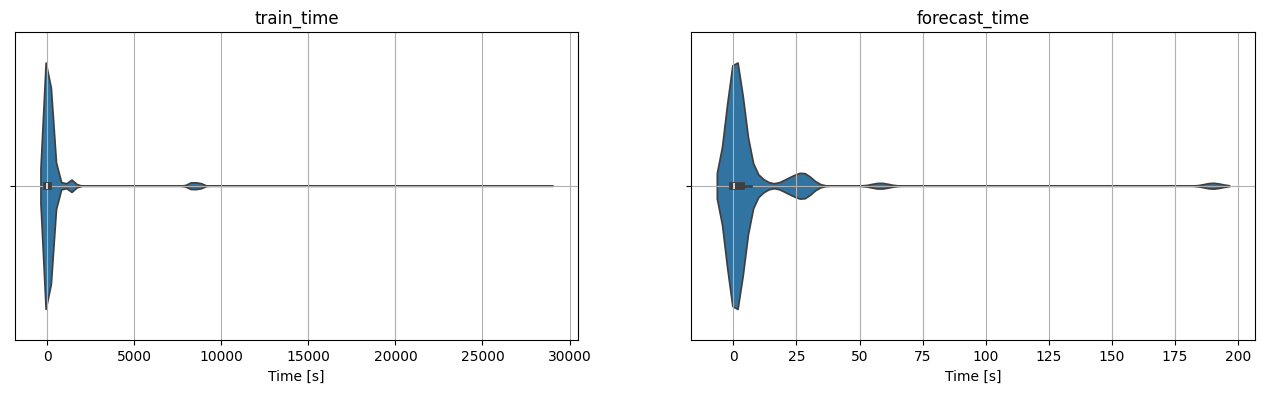

In [141]:
#labels = data.select_dtypes(include=np.number).columns.tolist()
times = ['train_time', 'forecast_time']
rows = 1

fig, axes = plt.subplots(nrows=rows, ncols=len(times)//rows, figsize=(16, 4))

for ax, time in zip(axes.flatten(), times):
    sns.violinplot(data[time], ax=ax, orient='h')
    ax.grid()
    ax.set_title(time)
    ax.set_xlabel('Time [s]')

plt.show()
fig.savefig('time_plot', dpi=300)

We can see, that there is an outlier w.r.t. to the train time.

In [142]:
data = data.drop(data[data['train_time'] > 10000].index)

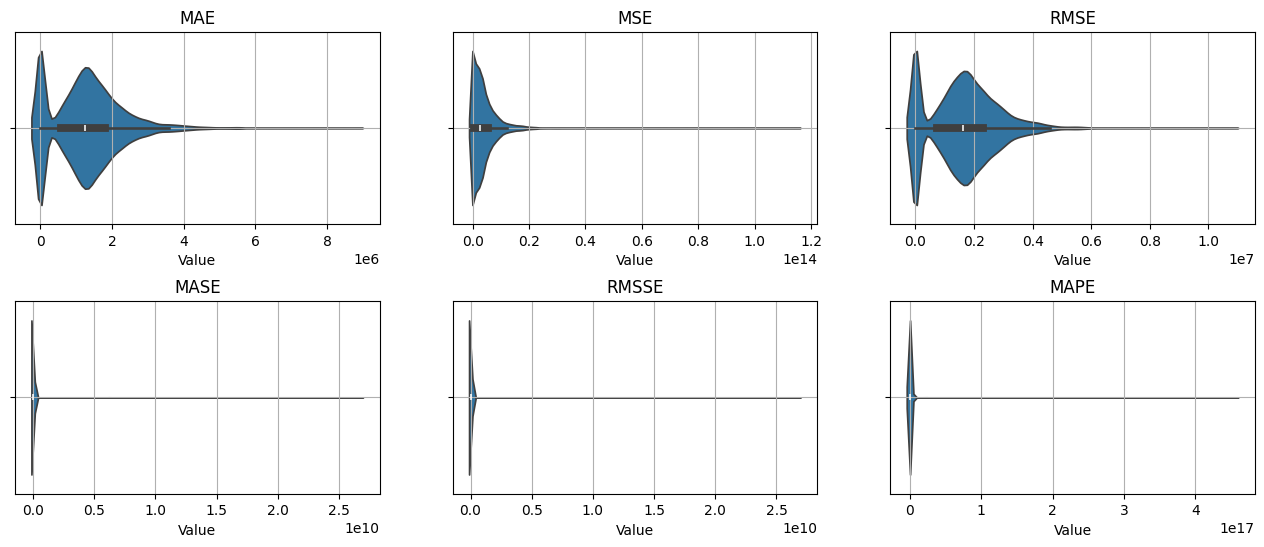

In [143]:
labels = data.select_dtypes(include=np.number).columns.tolist()
labels = [l for l in labels if l not in times]
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    sns.violinplot(data[label], ax=ax, orient='h')
    ax.grid()
    ax.set_title(label)
    ax.set_xlabel('Value')

plt.show()
fig.savefig('errors_plots', dpi=300)

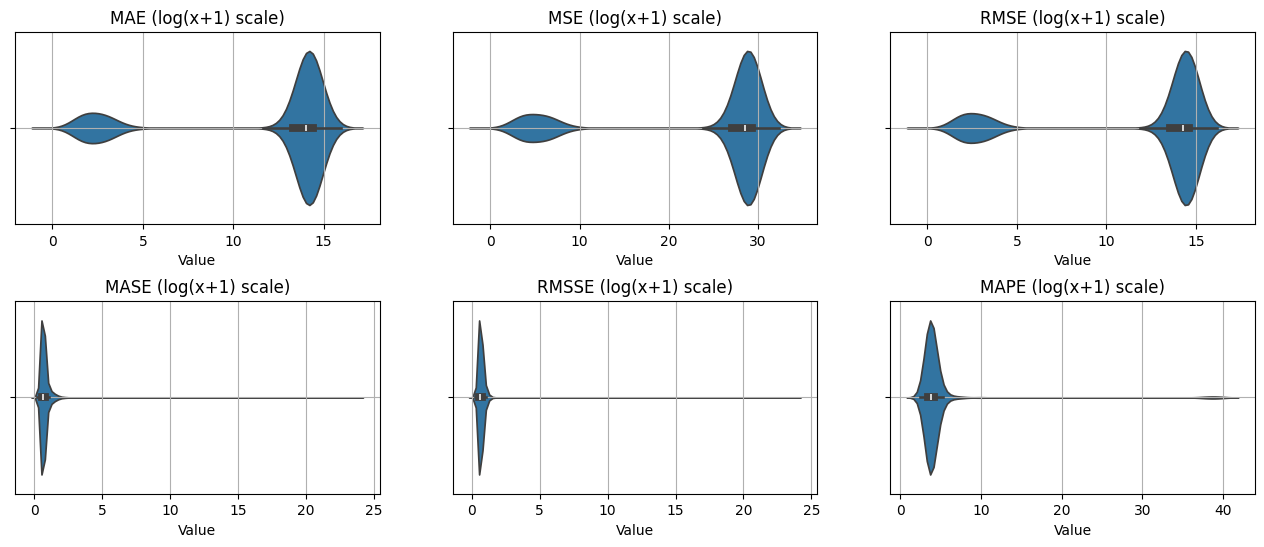

In [144]:
fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    sns.violinplot(np.log(data[label]+1), ax=ax, orient='h')
    ax.grid()
    ax.set_title(f'{label} (log(x+1) scale)')
    ax.set_xlabel('Value')

plt.show()
fig.savefig('log_errors_plots', dpi=300)